In [1]:
import torch
import matplotlib.pyplot as plt
from context import *

## Learn from Data

In [51]:
mdl = RGModel([1], 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [52]:
x_dat = torch.tensor([-1.]*50+[1.]*50)
x_dat = x_dat + 0.1*torch.randn_like(x_dat)
x_dat = x_dat[:,None,None]
x_dat.shape

torch.Size([100, 1, 1])

In [76]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.nll_loss(x_dat, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

-0.24 -0.27  0.38  3.27
-0.01 -0.05  0.40  3.78
-0.30 -0.33  0.44  3.45
-0.16 -0.20  0.45  3.22
-0.13 -0.17  0.40  3.09
-0.31 -0.34  0.36  3.14
-0.43 -0.46  0.35  3.29
 0.06  0.03  0.35  2.82
-0.14 -0.17  0.36  3.14
-0.24 -0.28  0.37  3.47


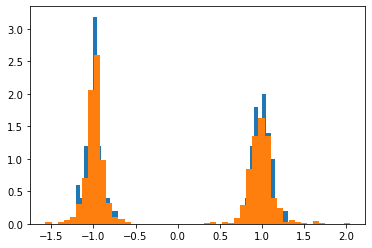

In [77]:
mdl.eval()
x_smp = mdl.rsample(1000)
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);

## Learn from Energy

In [78]:
mdl = RGModel([1], 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [79]:
def energy(x):
    return torch.squeeze((x-1)**2/(2*(1/3)**2))

In [91]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.free_loss(energy, 1000, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

 1.76  1.72  1.91  1.96
 1.68  1.64  1.96  1.84
 1.70  1.66  1.95  1.93
 1.70  1.66  1.96  1.94
 1.66  1.62  1.95  1.88
 1.62  1.58  1.99  1.83
 1.73  1.69  1.90  1.87
 1.72  1.68  2.05  1.98
 1.76  1.72  1.90  2.03
 1.68  1.64  1.97  1.99


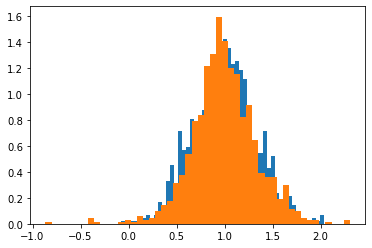

In [92]:
mdl.eval()
x_smp = mdl.rsample(1000)
x_dat = torch.randn_like(x_smp)/3+1
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);